In [1]:
import gymnax
# This is autoreload module code using jupyter magic
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.sparse.csgraph import dijkstra

import networkx as nx

from celluloid import Camera
from tqdm.auto import tqdm

from einops import repeat, rearrange

import flax.linen as nn

from jax.random import split

from algos.ppo_fixed_episode import make_ppo_funcs
from agents.basic import RandomAgent
import os
from mdps import smdp, csmdp
import viz_util


In [8]:
from gymnax.environments.spaces import Discrete, Box
import gymnax
for env_id in gymnax.registered_envs:
    env, env_params = gymnax.make(env_id)
    if isinstance(env.action_space(env_params), Discrete):
        print()
        print(env_id)
        print(env.observation_space(env_params).shape)



CartPole-v1
(4,)

Acrobot-v1
(6,)

MountainCar-v0
(2,)

Asterix-MinAtar
(10, 10, 4)

Breakout-MinAtar
(10, 10, 4)

Freeway-MinAtar
(10, 10, 7)

SpaceInvaders-MinAtar
(10, 10, 6)

Catch-bsuite
(10, 5)

DeepSea-bsuite
(8, 8)

MemoryChain-bsuite
(3,)

UmbrellaChain-bsuite
(3,)

DiscountingChain-bsuite
(2,)

MNISTBandit-bsuite
(28, 28)

SimpleBandit-bsuite
(1, 1)

FourRooms-misc
(4,)

MetaMaze-misc
(15,)

BernoulliBandit-misc
(4,)

GaussianBandit-misc
(4,)

Pong-misc
(30, 40, 3)


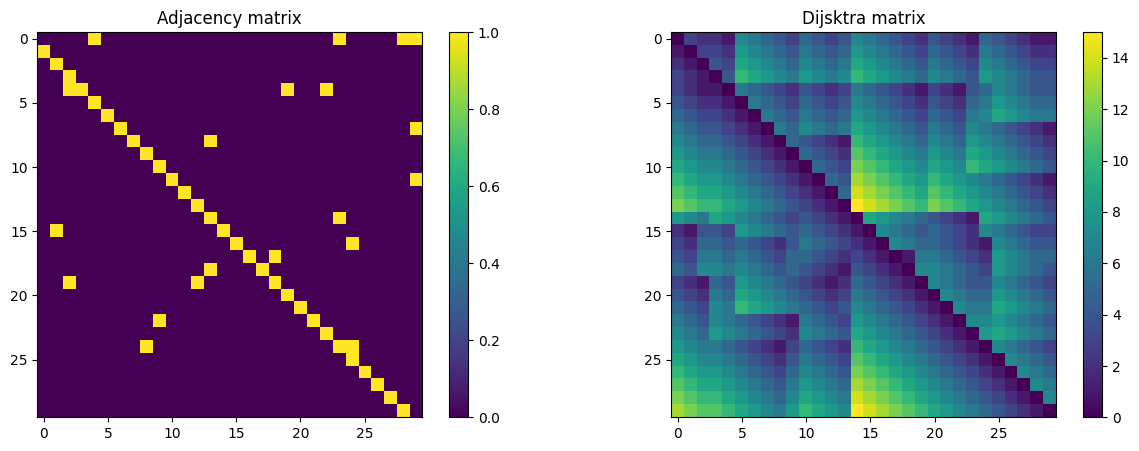

In [25]:
rng = jax.random.PRNGKey(1)

n_states, n_acts = 30, 3
trans_matrix = 1*jax.random.normal(rng, (n_acts, n_states, n_states)) + 3*jnp.eye(n_states, k=-1)
trans_matrix = jax.nn.softmax(trans_matrix*1e6, axis=-2)
A = trans_matrix.max(axis=0)
D = dijkstra(A)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Adjacency matrix')
plt.imshow(A, vmin=0, vmax=1)
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Dijsktra matrix')
plt.imshow(D)
plt.colorbar()

plt.show()



  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/ny/19b3c5357vzbxc3hyg919d9r0000gn/T/ipykernel_93800/1576931604.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*pos[i], c=[0, 0, 1, .5], marker='o', s=100, zorder=100, label='agent state')


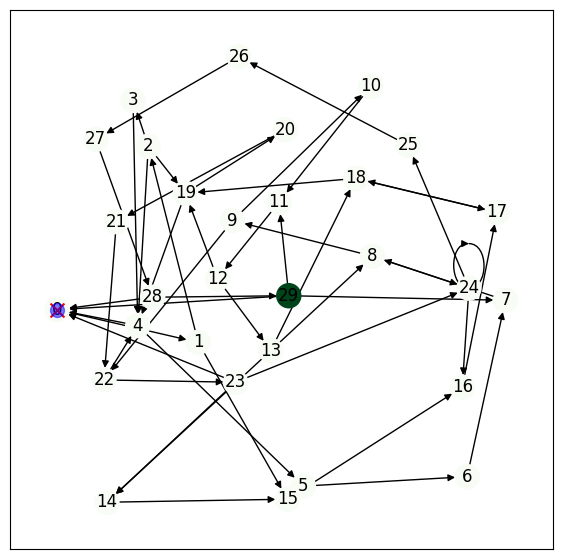

In [22]:
def generate_animation():
    np.random.seed(0)
    G = nx.DiGraph()
    G.add_nodes_from(list(range(n_states)))
    for act in range(n_acts):
        node_from = jnp.arange(n_states).tolist()
        node_to = jnp.argmax(trans_matrix[act], axis=-2).tolist()
        G.add_edges_from(list(zip(node_from, node_to)))

    # pos = nx.circular_layout(G)
    # pos = nx.shell_layout(G)
    pos = nx.spring_layout(G)

    # c = ['#1f77b4' for _ in range(n_states)]
    # c = [(31/255.,119/255.,180/255.,255/255.) for _ in range(n_states)]
    # c[0] = (0, 0, 1, 1)
    # c[-1] = (1, 0, 0, 1)
    # c = [(0, 1, 0, 1) for _ in range(n_states)]
    # rews = jnp.arange(n_states)
    rews = jnp.zeros(n_states)
    rews = rews.at[-1].set(1.)
    c = (rews-rews.min())/(rews.max()-rews.min() + 1e-5)

    fig = plt.figure(figsize=(7, 7))
    camera = Camera(fig)
    
    for i in tqdm(range(1)):
        nx.draw_networkx(G, with_labels=True, node_color=c, pos=pos, cmap='Greens')
        plt.scatter(*pos[0], c='r', marker='x', s=100, zorder=100, label='start state')
        plt.scatter(*pos[i], c=[0, 0, 1, .5], marker='o', s=100, zorder=100, label='agent state')
        camera.snap()
    animation = camera.animate()
    animation.save('animation.gif')

generate_animation()


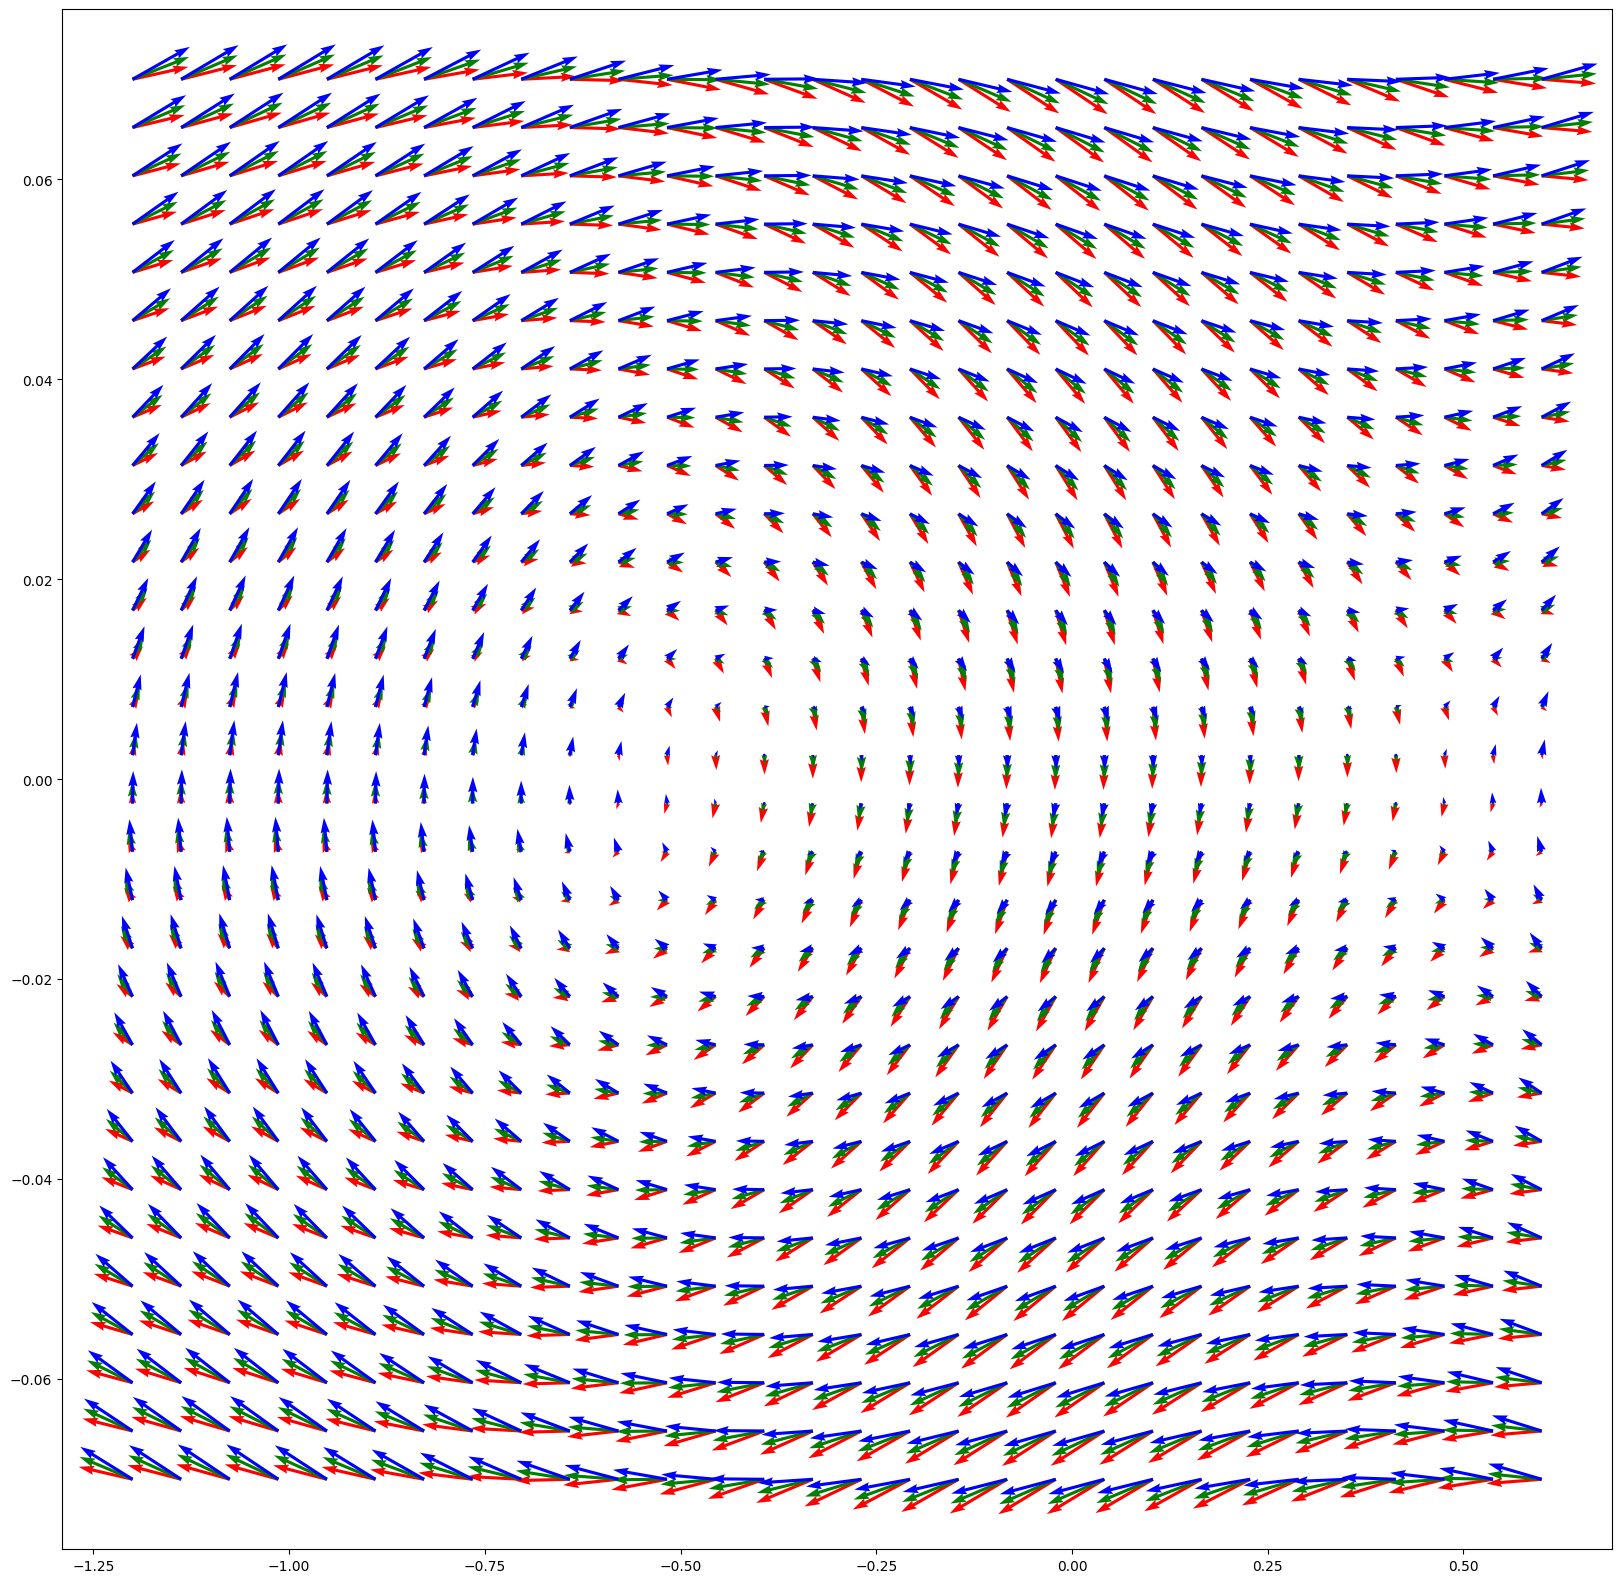

In [6]:
force, gravity = 0.001, 0.0025
p = jnp.linspace(-1.2, 0.6, 30)
v = jnp.linspace(-0.07, 0.07, 30)
p, v = jnp.meshgrid(p, v, indexing='ij')
acts = jnp.arange(3)

vn = v+(acts[:, None, None]-1)*force - jnp.cos(3*p)*gravity
pn = p+vn

p, v = repeat(p, 'i j -> 3 i j').flatten(), repeat(v, 'i j -> 3 i j').flatten()
pn, vn = pn.flatten(), vn.flatten()

c = ['r']*900 + ['g']*900 + ['b']*900

plt.figure(figsize=(20, 20))
plt.quiver(p, v, pn-p, vn-v, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)
plt.show()

In [7]:
class Trans(nn.Module):
    d_state: int
    n_acts: int
    delta: True

    def setup(self):
        self.seq = nn.Sequential([
            nn.Dense(self.d_state, kernel_init=jax.nn.initializers.orthogonal(), bias_init=jax.nn.initializers.normal()),
            nn.tanh,
            nn.Dense(self.d_state),
            nn.tanh,
            nn.Dense(self.n_acts*self.d_state),
        ])

    def __call__(self, state):
        state_n = 0.3*self.seq(state).reshape(self.n_acts, self.d_state)
        if self.delta:
            state_n = state + state_n
        return state_n

rng = jax.random.PRNGKey(2)
trans = Trans(2, 3, True)
rng, _rng = jax.random.split(rng)
params = trans.init(_rng, jnp.zeros(2))


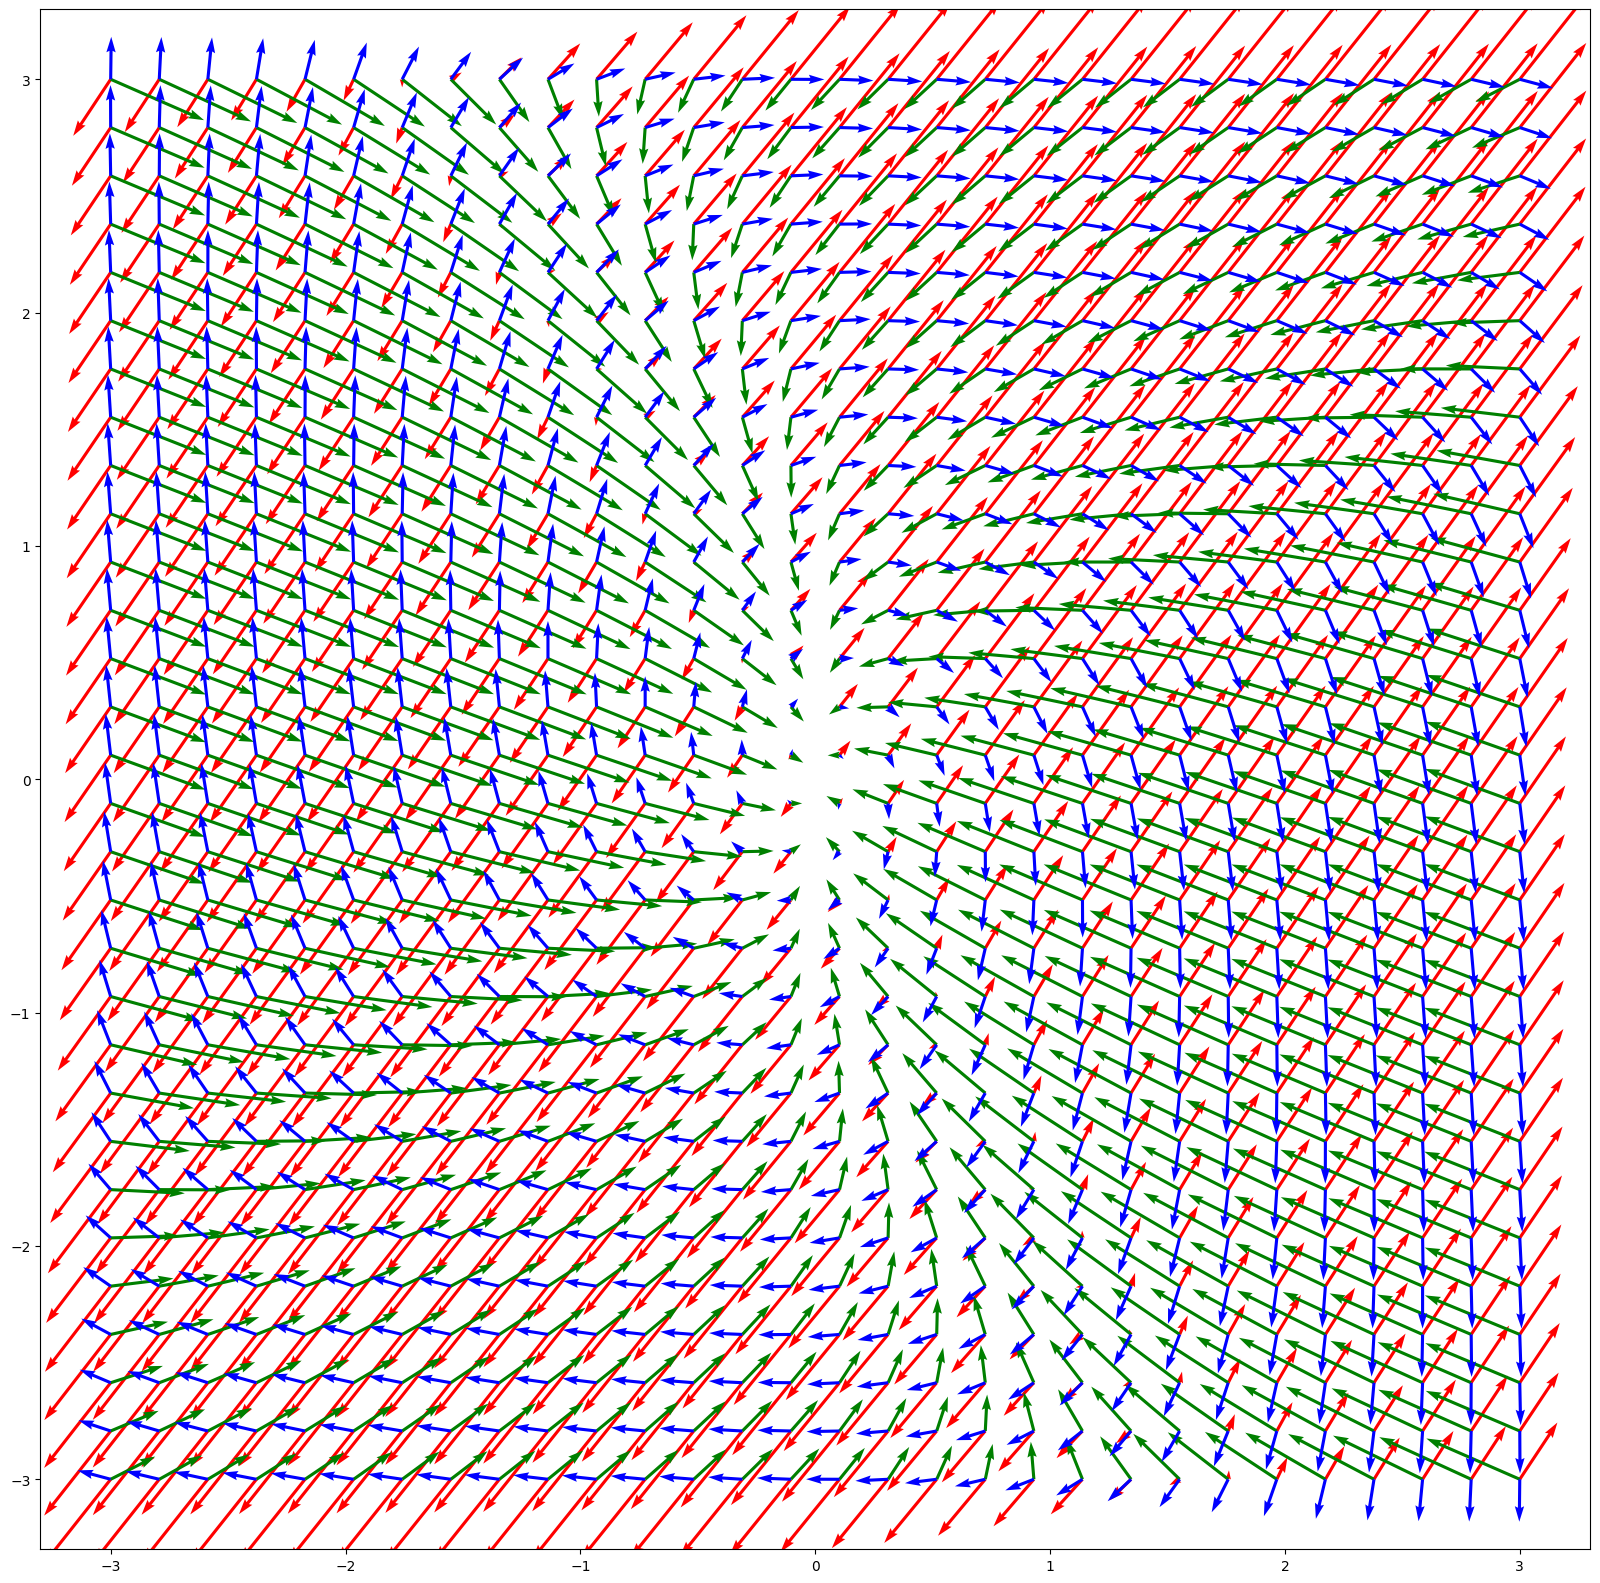

In [8]:
x = jnp.linspace(-3, 3, 30)
y = jnp.linspace(-3, 3, 30)
x, y = jnp.meshgrid(x, y, indexing='ij')
acts = jnp.arange(3)

x = jnp.stack([x, y], axis=-1)
xn = jax.vmap(jax.vmap(partial(trans.apply, params)))(x)
xn = rearrange(xn, 'i j a s -> a i j s')

x = repeat(x, 'i j s -> 3 i j s')
x, y = x[:, :, :, 0].flatten(), x[:, :, :, 1].flatten()
xn, yn = xn[:, :, :, 0].flatten(), xn[:, :, :, 1].flatten()

c = ['r']*900 + ['g']*900 + ['b']*900

plt.figure(figsize=(20, 20))
plt.quiver(x, y, xn-x, yn-y, angles='xy', scale_units='xy', scale=1, width=0.002, color=c)
plt.show()

In [5]:
from mdps.natural_mdps import MountainCar
from gymnax.environments.classic_control.mountain_car import EnvState
s_min, s_max = jnp.array([-1.2, -0.07]), jnp.array([0.6, 0.07])
class MyMountainCar(MountainCar):
    def reset_env(self, rng, params):
        obs, state = super().reset_env(rng, params)
        state = jnp.array([state.position, state.velocity])
        state = (state - s_min)/(s_max - s_min) * 6 - 3.
        return obs, state
    def step_env(self, rng, state, act, params):
        state = (state + 3.)/6 * (s_max - s_min) + s_min
        obs, state, rew, done, info = super().step_env(rng, EnvState(position=state[0], velocity=state[1], time=0), act, params)
        state = jnp.array([state.position, state.velocity])
        state = (state - s_min)/(s_max - s_min) * 6 - 3.
        return obs, state, rew, done, info
    


In [6]:
def random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256):
    rng, _rng = split(rng)
    states = []
    obs, state = jax.vmap(env.reset, in_axes=(0, None))(split(rng, n_envs), env_params)
    for t in range(n_steps):
        states.append(state)
        rng, _rng = split(rng)
        act = jax.random.randint(_rng, (n_envs,), 0, env.action_space(None).n)
        rng, _rng = split(rng)
        obs, state, rew, done, info = jax.vmap(env.step, in_axes=(0, 0, 0, None))(split(_rng, n_envs), state, act, env_params)
    states = jnp.stack(states, axis=1)
    return states


/Users/akarshkumar0101/miniconda3/lib/python3.10/site-packages/gymnax/environments/spaces.py:38: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ).astype(self.dtype)
/var/folders/ny/19b3c5357vzbxc3hyg919d9r0000gn/T/ipykernel_93800/3265492447.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*states.reshape(-1, 2).T, c=[1, 0, 0, .01])


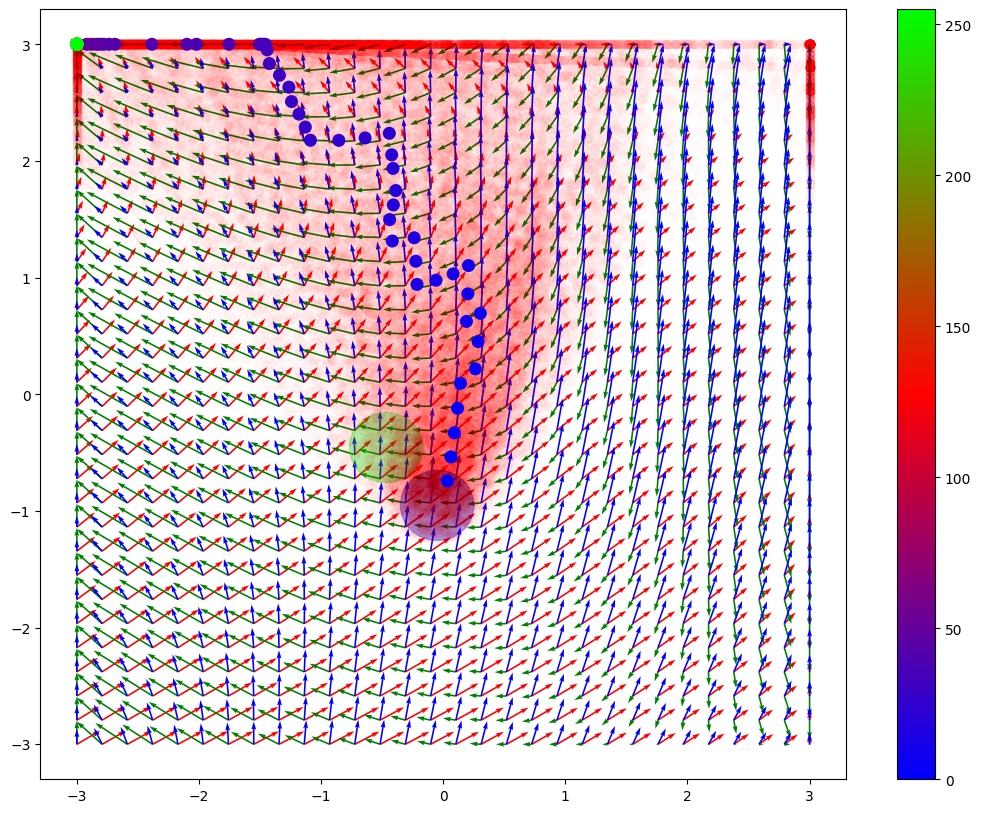

In [6]:
model_init = csmdp.Init(d_state=2)
model_trans = csmdp.Transition2(d_state=2, n_acts=3, delta=True)
model_obs = smdp.IdentityObs()
model_rew = csmdp.Reward(d_state=2)
model_done = smdp.NeverDone()
env = smdp.SyntheticMDP(model_init, model_trans, model_obs, model_rew, model_done)

rng = jax.random.PRNGKey(0)
env_params = env.sample_params(rng)
states = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)

plt.figure(figsize=(13, 10))
viz_util.plot_env_dynamics(env, env_params, xlim=(-3, 3), ylim=(-3, 3))
viz_util.plot_start_end_states(env, env_params)
plt.scatter(*states.reshape(-1, 2).T, c=[1, 0, 0, .01])
viz_util.plot_trajectory(states[0])

/var/folders/ny/19b3c5357vzbxc3hyg919d9r0000gn/T/ipykernel_93800/2192909528.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*states.reshape(-1, 2).T, c=[1, 0, 0, .01])


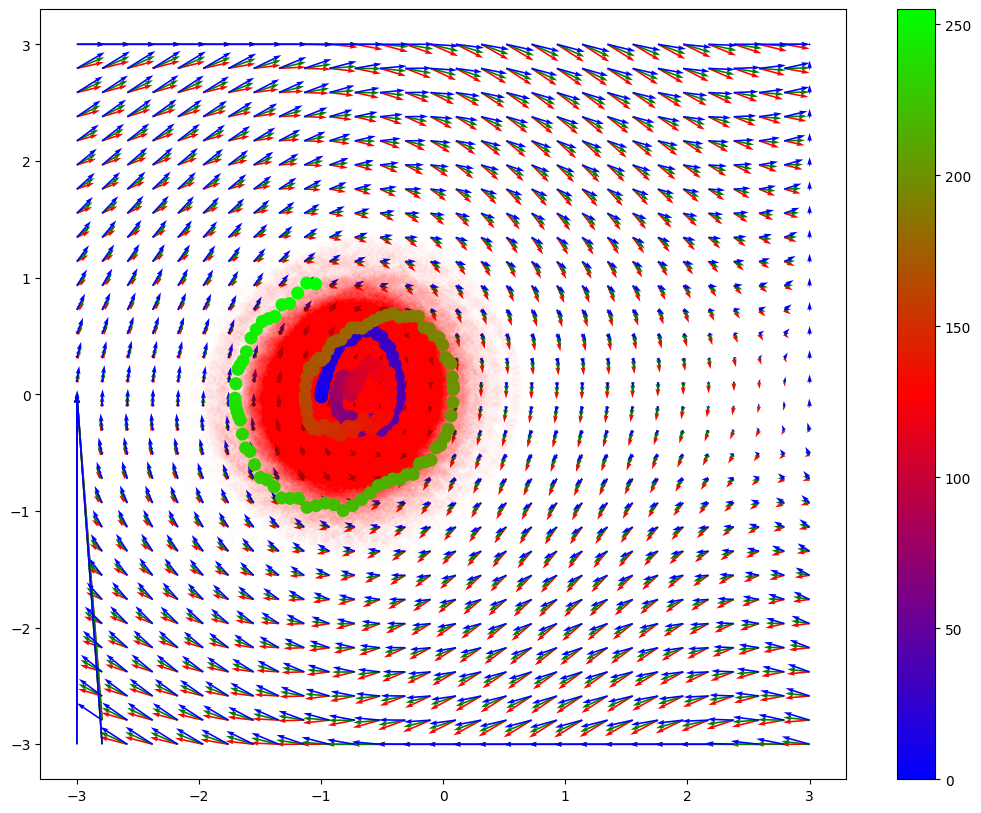

In [7]:
env = MyMountainCar()

rng = jax.random.PRNGKey(3)
env_params = env.sample_params(rng)
states = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)

plt.figure(figsize=(13, 10))
viz_util.plot_env_dynamics(env, env_params, xlim=(-3, 3), ylim=(-3, 3))
# viz_util.plot_start_end_states(env, env_params)
plt.scatter(*states.reshape(-1, 2).T, c=[1, 0, 0, .01])
viz_util.plot_trajectory(states[0])


In [11]:
model_init = csmdp.Init(d_state=2)
model_trans = csmdp.Transition2(d_state=2, n_acts=3, delta=True)
model_obs = smdp.IdentityObs()
model_rew = csmdp.Reward(d_state=2)
model_done = smdp.NeverDone()
env = smdp.SyntheticMDP(model_init, model_trans, model_obs, model_rew, model_done)

for i in tqdm(range(60)):
    rng = jax.random.PRNGKey(i)
    env_params = env.sample_params(rng)
    states = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)

    plt.figure(figsize=(13, 10))
    viz_util.plot_env_dynamics(env, env_params, xlim=(-3, 3), ylim=(-3, 3))
    viz_util.plot_start_end_states(env, env_params)
    plt.scatter(*states.reshape(-1, 2).T, c=[1, 0, 0, .01])
    viz_util.plot_trajectory(states[0])
    
    os.makedirs('../data/exp_ncsmdp/viz', exist_ok=True)
    plt.savefig(f'../data/exp_ncsmdp/viz/smdp_{i}.png')
    plt.close()

  0%|          | 0/60 [00:00<?, ?it/s]

/var/folders/ny/19b3c5357vzbxc3hyg919d9r0000gn/T/ipykernel_93800/3670004318.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*states.reshape(-1, 2).T, c=[1, 0, 0, .01])


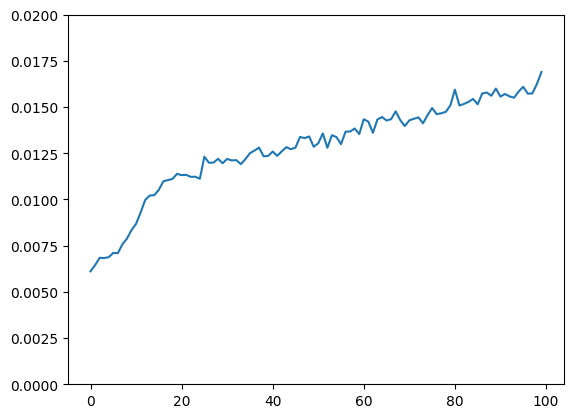

In [62]:
import pickle
with open('../data/exp_ncsmdp/exp1/rew.pkl', 'rb') as f:
    rew = pickle.load(f)
plt.plot(rew[0].mean(axis=-1).reshape(100, 1000).mean(axis=-1))
plt.ylim(0, .020)

with open('../data/exp_ncsmdp/exp1/agent_params.pkl', 'rb') as f:
    agent_params = pickle.load(f)
    agent_params = jax.tree_map(lambda x: x[0], agent_params)

In [94]:
env = MyMountainCar()
from mdps.wrappers_mine import MetaRLWrapper, DoneObsActRew
env = MetaRLWrapper(env, n_trials=2, n_steps_trial=128)
env = DoneObsActRew(env)

from agents.linear_transformer import LinearTransformerAgent
agent = LinearTransformerAgent(n_acts=3, n_steps=256, n_layers=2, n_heads=4, d_embd=128)

init_agent_env, eval_step, ppo_step = make_ppo_funcs(agent, env, n_envs=1024, n_steps=256)
rng = jax.random.PRNGKey(0)
carry = init_agent_env(rng)

_, buffer_rand = eval_step(carry, None)

rng, train_state, env_params, agent_state, obs, env_state = carry
train_state = train_state.replace(params=agent_params)
carry = rng, train_state, env_params, agent_state, obs, env_state

_, buffer_pre = eval_step(carry, None)


In [95]:
print(buffer_rand['rew'].max(axis=0).mean())
print(buffer_pre['rew'].max(axis=0).mean())


-0.3911757
-0.22750485


In [96]:
print(buffer_rand['env_state']['_state'].var(axis=(0, 1)))
print(buffer_pre['env_state']['_state'].var(axis=(0, 1)))


[0.05409273 0.06580602]
[0.1119132  0.11545269]


In [97]:

print(buffer_rand['env_state']['_state'].max(axis=(0, 1)))
print(buffer_pre['env_state']['_state'].max(axis=(0, 1)))


[0.32717156 1.2132587 ]
[0.86522245 1.190156  ]


/tmp/ipykernel_3012552/1115559518.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*buffer_pre['env_state']['_state'].reshape(-1, 2).T, c=[0, 0, 1, .01])
/tmp/ipykernel_3012552/1115559518.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*buffer_rand['env_state']['_state'].reshape(-1, 2).T, c=[1, 0, 0, .01])


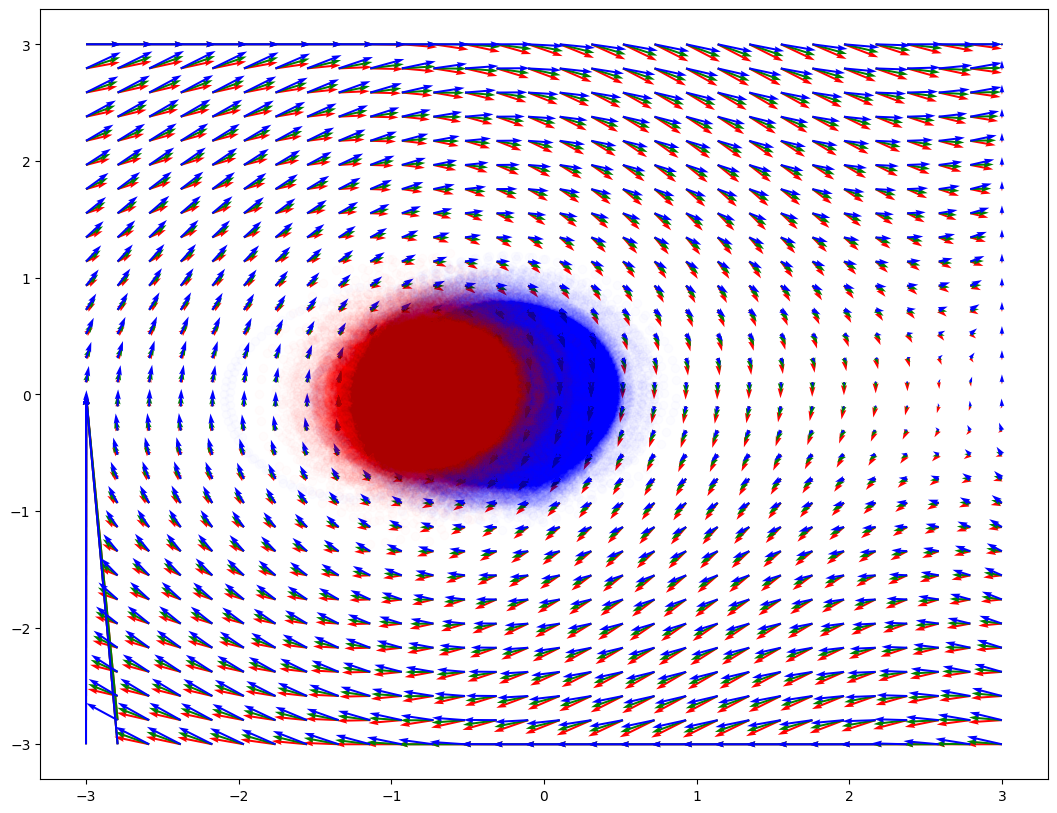

In [107]:
env = MyMountainCar()
rng = jax.random.PRNGKey(3)
env_params = env.sample_params(rng)

plt.figure(figsize=(13, 10))
viz_util.plot_env_dynamics(env, env_params, xlim=(-3, 3), ylim=(-3, 3))
plt.scatter(*buffer_pre['env_state']['_state'].reshape(-1, 2).T, c=[0, 0, 1, .01])
plt.scatter(*buffer_rand['env_state']['_state'].reshape(-1, 2).T, c=[1, 0, 0, .01])

# viz_util.plot_trajectory(states[0])




  0%|          | 0/30 [00:00<?, ?it/s]

/var/folders/ny/19b3c5357vzbxc3hyg919d9r0000gn/T/ipykernel_99544/2368312952.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*states.reshape(-1, 2).T, c=[1, 0, 0, .01])


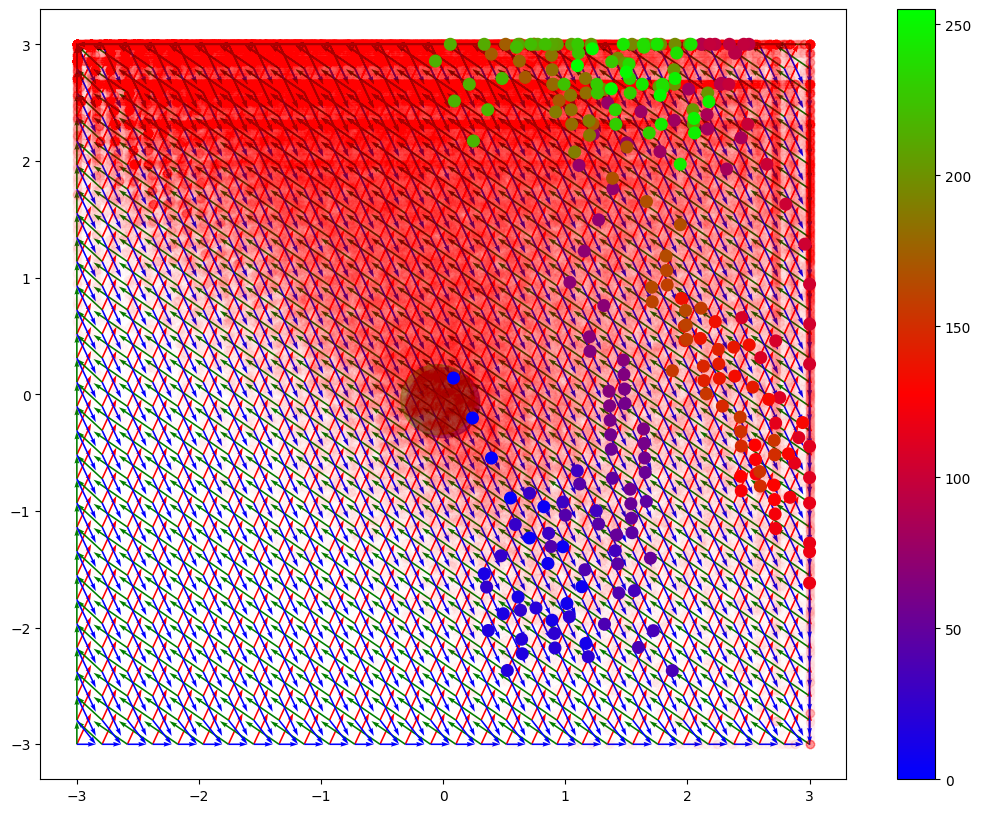

In [50]:
model_init = csmdp.Init(d_state=2)
model_trans = csmdp.Transition2(d_state=2, n_acts=3, delta=True)
model_obs = smdp.IdentityObs()
model_rew = csmdp.Reward(d_state=2)
model_done = smdp.NeverDone()
env = smdp.SyntheticMDP(model_init, model_trans, model_obs, model_rew, model_done)

rng = jax.random.PRNGKey(0)
env_params = env.sample_params(rng)

def loss_fn(env_params):
    states = random_agent_collect(rng, env, env_params, n_envs=64, n_steps=128)
    return -states.var(axis=(0)).mean()
grad_fn = jax.grad(loss_fn)

env_params = jax.tree_map(lambda x: x*1e-1, env_params)
for i in tqdm(range(30)):
    grad = grad_fn(env_params)
    env_params = jax.tree_map(lambda x, y: x - 1e-1*y, env_params, grad)

states = random_agent_collect(rng, env, env_params, n_envs=1024, n_steps=256)
plt.figure(figsize=(13, 10))
viz_util.plot_env_dynamics(env, env_params, xlim=(-3, 3), ylim=(-3, 3))
viz_util.plot_start_end_states(env, env_params)
plt.scatter(*states.reshape(-1, 2).T, c=[1, 0, 0, .01])
viz_util.plot_trajectory(states[0])



In [103]:
# maybe bias the transition matrix to have bound state_i-state_j must be small id...

In [ ]:
# graph the correlation of between phi(s), phi(s') vs the time difference between s and s'
# gives and idea how smooth phi is temporally